In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

# Get data from 10x

In [39]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz -P data/
    

--2023-01-18 19:54:37--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296410621 (283M) [application/x-tar]
Saving to: ‘data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz’

vdj_v1_hs_aggregate 100%[===================>] 282.68M  3.50MB/s    in 2m 51s  

2023-01-18 19:57:28 (1.66 MB/s) - ‘data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz’ saved [296410621/296410621]



In [83]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv -P data/

--2023-01-19 07:51:15--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33851101 (32M) [text/csv]
Saving to: ‘data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv’

vdj_v1_hs_aggregate 100%[===================>]  32.28M  6.81MB/s    in 4.7s    

2023-01-19 07:51:22 (6.81 MB/s) - ‘data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv’ saved [33851101/33851101]



In [41]:
!gunzip data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz

In [43]:
!tar -xvf data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar -C data/

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


In [45]:
!gunzip data/filtered_feature_bc_matrix/matrix.mtx.gz
!gunzip data/filtered_feature_bc_matrix/features.tsv.gz
!gunzip data/filtered_feature_bc_matrix/barcodes.tsv.gz

# Code

In [46]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]

In [47]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    return data_c

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    data_c = data_c[data_c['cdr3']!='None']
    return data_c

### Normalization code

In [48]:
def sum_counts(data, cell_col_name, count_col_name, cell):
    return sum(data[data[cell_col_name]==cell][count_col_name])

def norm_logp_with_total_average(data, cell_id_col, count_col):
    # total count for cell
    cell_all_counts = pd.DataFrame(data[cell_id_col].drop_duplicates())
    cell_all_counts['counts']= cell_all_counts[cell_id_col].apply(lambda x: sum_counts(data_c_all,cell_id_col,count_col,x))
    
    cell_all_counts_dict = pd.Series(cell_all_counts['counts'].values,index=cell_all_counts[cell_id_col]).to_dict()
    ## average total count for cell
    average_total_count = cell_all_counts['counts'].mean()
    ## normalize log(1 + count / (total count for cell) * (average total count for cell)) 
    data['count']= data.apply(lambda row : math.log(1 + row[count_col]/cell_all_counts_dict[row[cell_id_col]]*average_total_count),axis=1)
    return data
    
    
def norm_logp(data, count_col):
    data[count_col]= data[count_col].apply(lambda x : math.log1p(x))
    return data
    

### Pivot code

In [49]:
def pivot_data_old(data):
    data = data[['count','cdr3','value']]
    data = data.pivot_table('count','cdr3','value')
    data = data.fillna(0)
    return data

In [155]:
def pivot_data(data):
    data = data[['count','barcode','value']]
    data = data.pivot_table('count','barcode','value')
    data = data.fillna(0)
    return data

### PCA code

In [50]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

### TSNE code

In [51]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

## Reading and processing raw data

In [74]:
barcodes = read_barcodes('data/filtered_feature_bc_matrix/barcodes.tsv')
features = read_features('data/filtered_feature_bc_matrix/features.tsv')
matrix = read_matrix('data/filtered_feature_bc_matrix/matrix.mtx')
matrix = merge_matrix(matrix,barcodes,features)
matrix = get_value_matrix(matrix)

matrix = matrix[matrix['type']=='Antibody Capture']
matrix = matrix[matrix['value_type']!='TotalSeqC']
matrix_t = get_tetramer_matrix(matrix)

In [75]:
matrix_t.size

819904

In [76]:
matrix_t.head(5)

,barcode,value,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,AAKGRGAAL,76112470
1,TTTGTCATCAGGTAAA-40,QYDPVAALF,AAKGRGAAL,2
2,TTTGTCATCAGGTAAA-40,KLGGALQAK,AAKGRGAAL,1
3,TTTGTCATCAGGTAAA-40,NLVPMVATV,AAKGRGAAL,1
4,TTTGTCATCAGGTAAA-40,QPRAPIRPI,AAKGRGAAL,1


In [84]:
data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot = prep_annot_data(data)
data_c = data_c_annot.copy()
data_c = merge_anot_matrix(data_c,matrix_t)
data_c['count'].mean()

375.7858468262266

In [85]:
data_c['count'].median()

2.0

In [86]:
data_c_all = data_c.copy()

In [88]:
v_param = '190123'
data_c_all_path = 'data_scripts/10x_tetramer_annot' + v_param + '.txt'
matrix_path = 'data_scripts/10x_tetramer_matrix' + v_param + '.txt'
data_c_all.to_csv(data_c_all_path, sep='\t', index = False)
matrix_t.to_csv(matrix_path, sep='\t', index = False)

# Analysis

In [89]:
data_c_all = pd.read_csv(data_c_all_path, sep='\t')
data_c_all.head(5)

,cdr3,count,tetramer,value,barcode
0,CATSRDRGHGDTIYF,6,KLGGALQAK,KLGGALQAK,AAACCTGAGAGTGAGA-23
1,CATSRDRGHGDTIYF,1,KLGGALQAK,AVFDRKSDAK,AAACCTGAGAGTGAGA-23
2,CATSRDRGHGDTIYF,1,KLGGALQAK,RLRAEAQVK,AAACCTGAGAGTGAGA-23
3,CASSLYSATGELFF,451,AVFDRKSDAK,AVFDRKSDAK,AAACCTGAGATTACCC-16
4,CASSLYSATGELFF,4,AVFDRKSDAK,KLGGALQAK,AAACCTGAGATTACCC-16


In [90]:
matrix_t = pd.read_csv(matrix_path, sep='\t')
matrix_t.head(5)

,barcode,value,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,AAKGRGAAL,76112470
1,TTTGTCATCAGGTAAA-40,QYDPVAALF,AAKGRGAAL,2
2,TTTGTCATCAGGTAAA-40,KLGGALQAK,AAKGRGAAL,1
3,TTTGTCATCAGGTAAA-40,NLVPMVATV,AAKGRGAAL,1
4,TTTGTCATCAGGTAAA-40,QPRAPIRPI,AAKGRGAAL,1


### logP normalization

Нормировка logp
Без отсечки по кайнтам

In [194]:
data_c_n = norm_logp(data_c_all, 'count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

In [195]:
data_c_p.head(5)

value,AAKGRGAAL,ALIAPVHAV,AVFDRKSDAK,AYAQKIFKI,AYSSAGASI,CLGGLLTMV,CLLGTYTQDV,CLLWSFQTSA,CYTWNQMNL,ELAGIGILTV,...,SLEGGGLGY,SLFNTVATL,SLFNTVATLY,SLLMWITQV,SLYNTVATLY,STEGGGLAY,TPRVTGGGAM,VTEHDTLLY,YLLEMLWRL,YLNDHLEPWI
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAGTGAGA-23,0.000000,0.000000,0.400800,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
AAACCTGAGATTACCC-16,0.000000,0.250327,0.432214,0.0,0.250327,0.0,0.0,0.0,0.0,0.250327,...,0.0,0.250327,0.0,0.000000,0.250327,0.250327,0.000000,0.000000,0.0,0.000000
AAACCTGAGGCTCATT-34,0.000000,0.341973,0.380084,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.341973,0.0,0.000000
AAACCTGAGGGAGTAA-40,0.113289,0.155078,0.318000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.113289,0.000000,0.113289,0.113289,0.000000,0.0,0.113289
AAACCTGAGGTGCACA-13,0.000000,0.000000,0.478790,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [196]:
pca_df, pca_model = pca(data_c_p,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

pca_df_data=pca_df_data.merge(barcode_tetramer, how='right', on='barcode')

<AxesSubplot:>

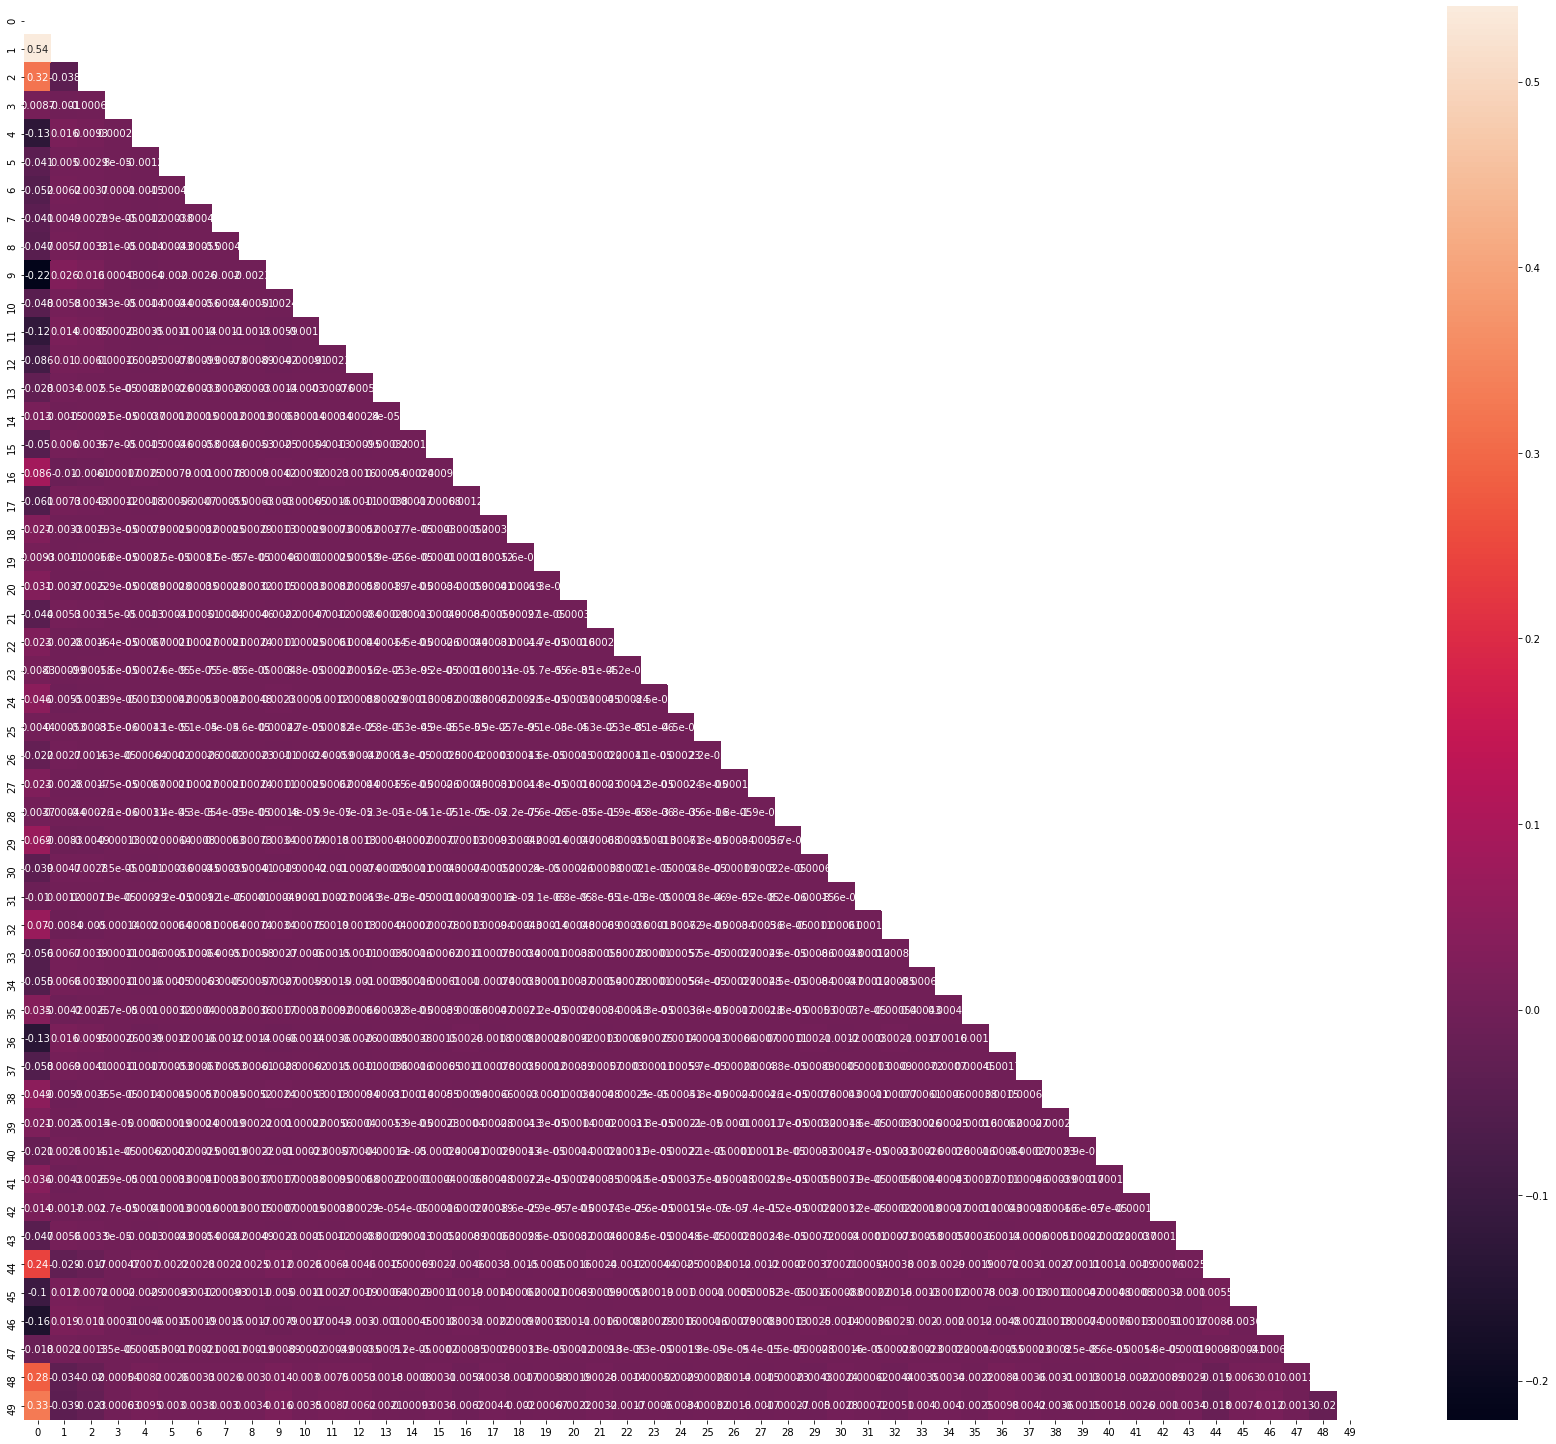

In [197]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on pca

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


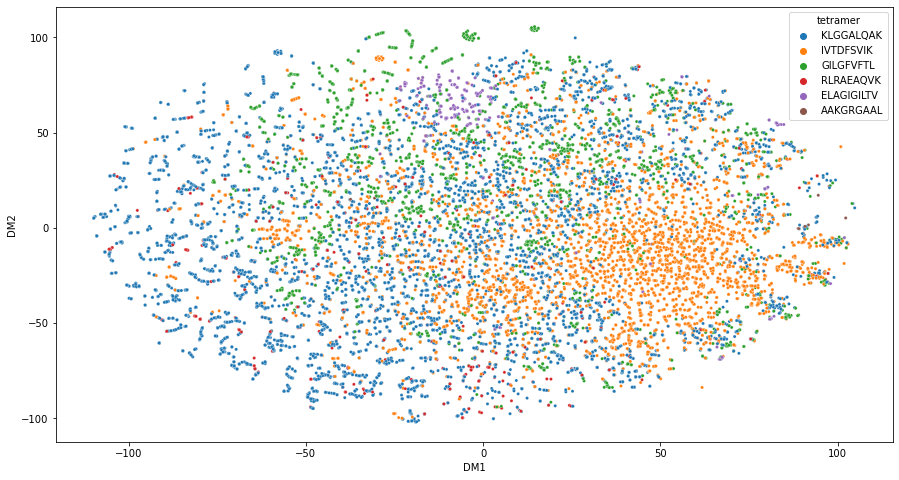

In [198]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


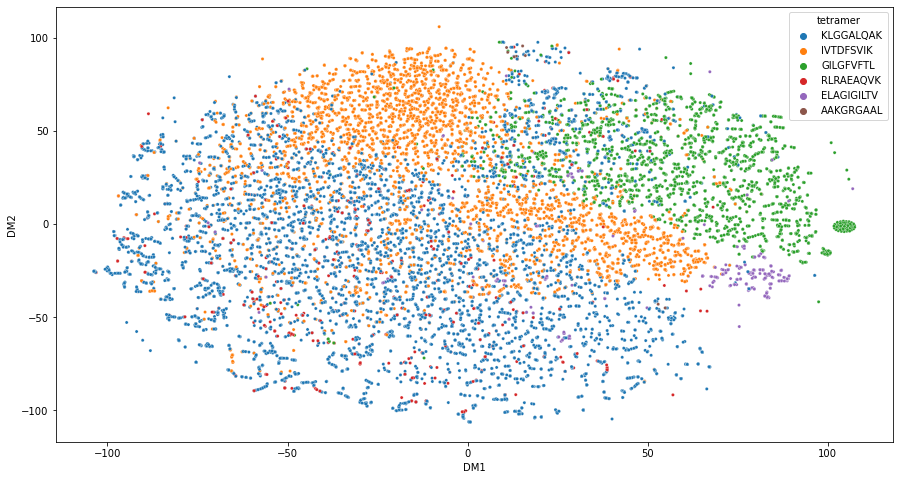

In [201]:
X_embedded = tsne(data_c_p,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### Another normalization with total and avegage

In [209]:
data_c_n = norm_logp_with_total_average(data_c_all, 'barcode','count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

In [210]:
pca_df, pca_model = pca(data_c_p,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

<AxesSubplot:>

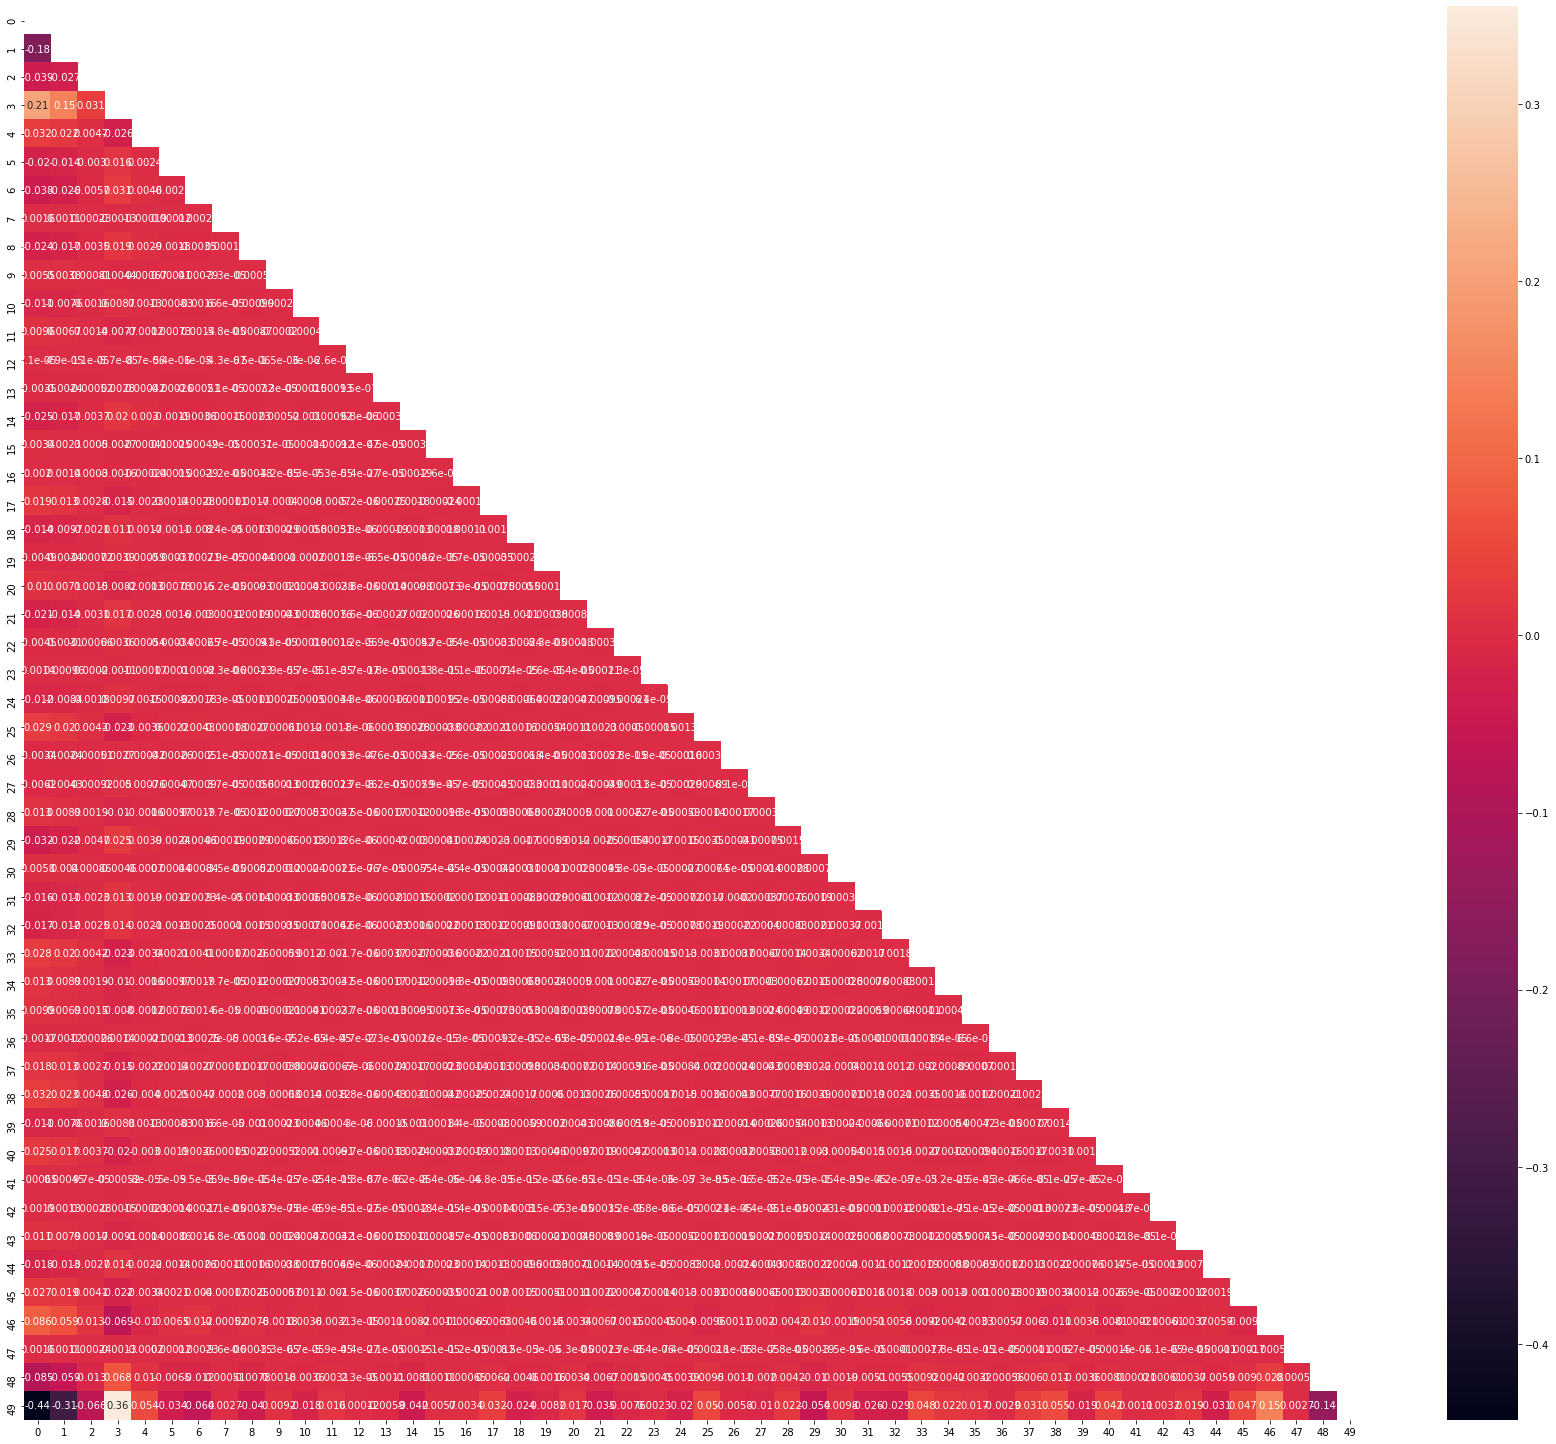

In [211]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on pca

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


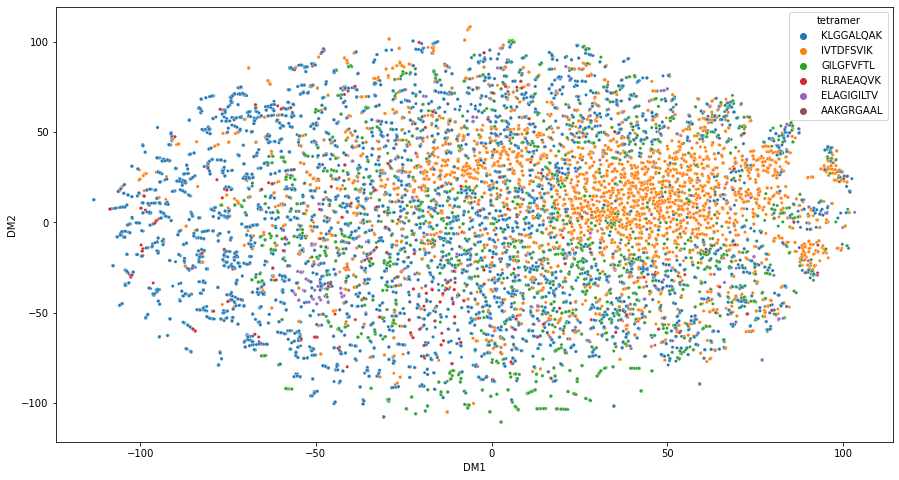

In [213]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


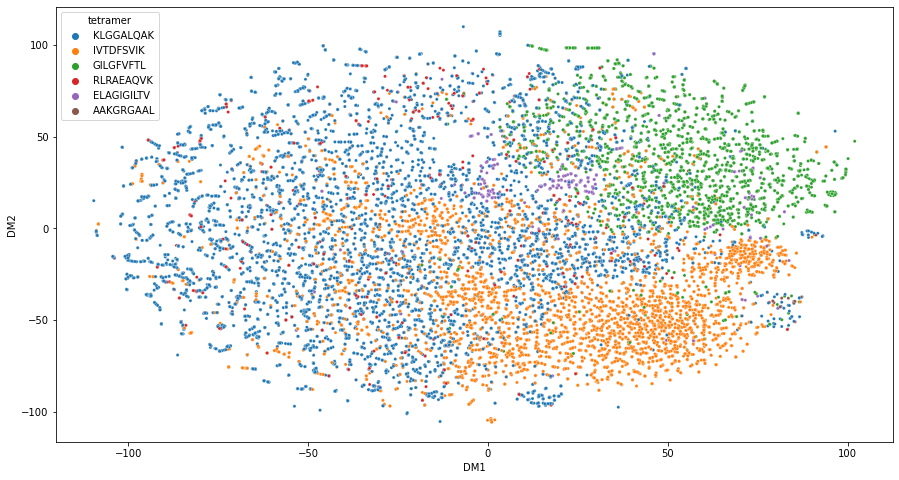

In [214]:
X_embedded = tsne(data_c_p,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### LogP without KLG

In [232]:
data_c_filter = data_c_all[data_c_all['tetramer']!='KLGGALQAK']

In [233]:
data_c_n = norm_logp(data_c_filter, 'count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

/home/yuliajk/.conda-envs/python3/bin/ipython:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [234]:
data_c_p_tetramer = data_c_p.copy()
data_c_p_tetramer = data_c_p_tetramer.merge(barcode_tetramer, on='barcode')

In [235]:
pca_df, pca_model = pca(data_c_p,49)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

pca_df_data=pca_df_data.merge(barcode_tetramer, how='right', on='barcode' )

<AxesSubplot:>

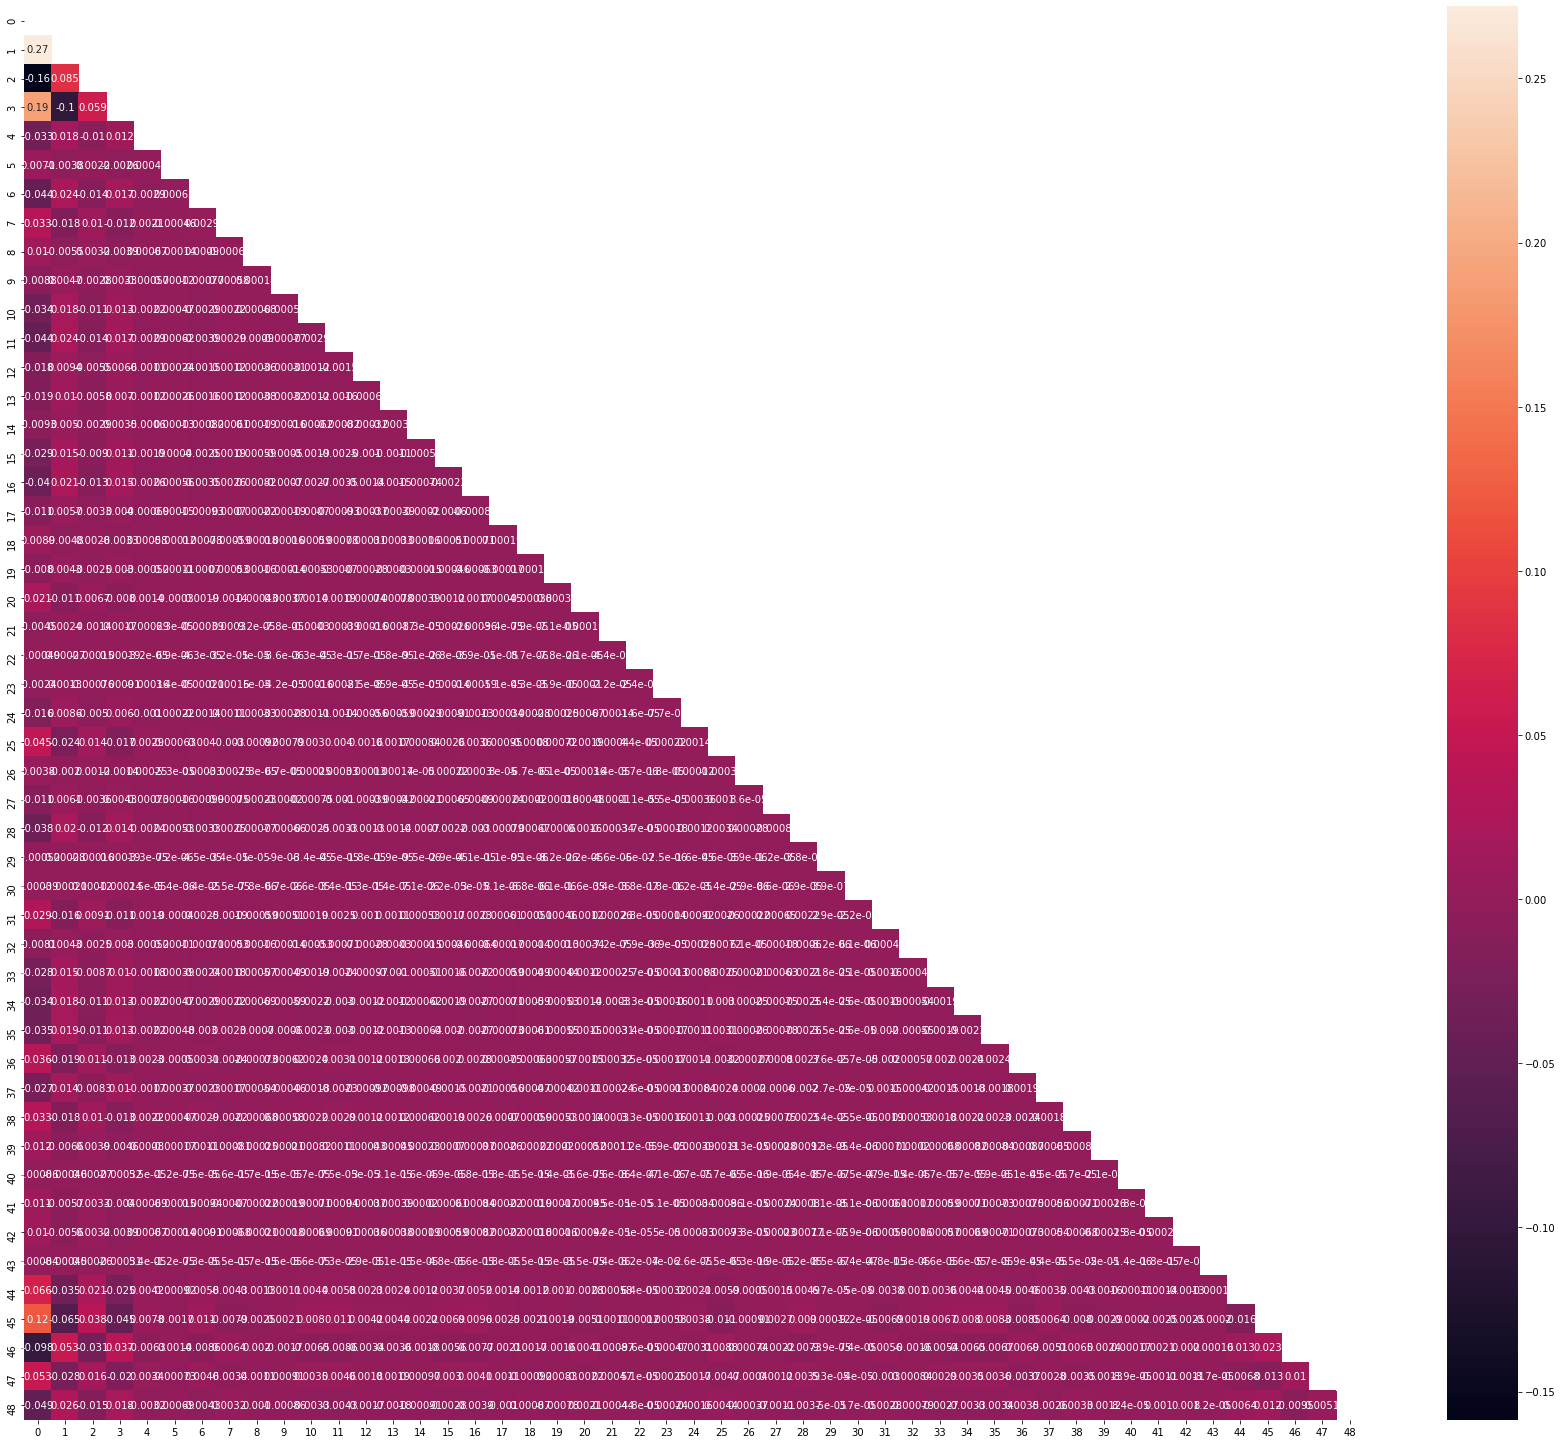

In [236]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on PCA

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


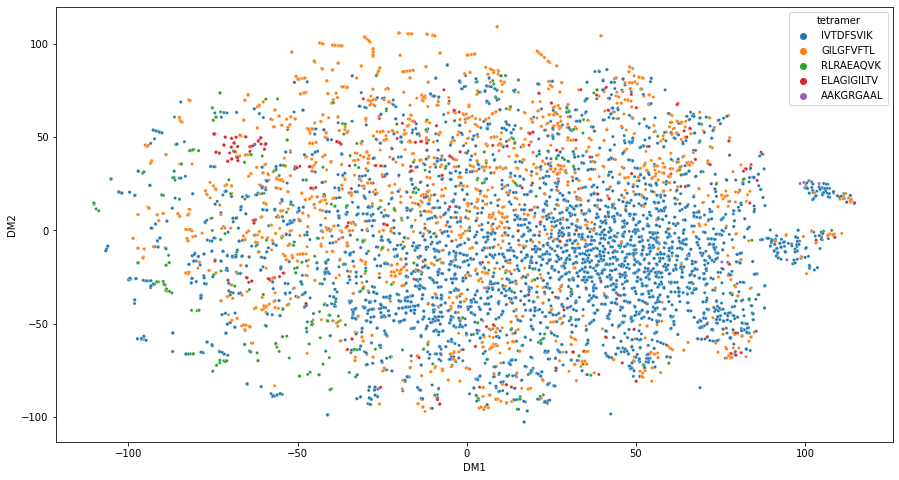

In [237]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


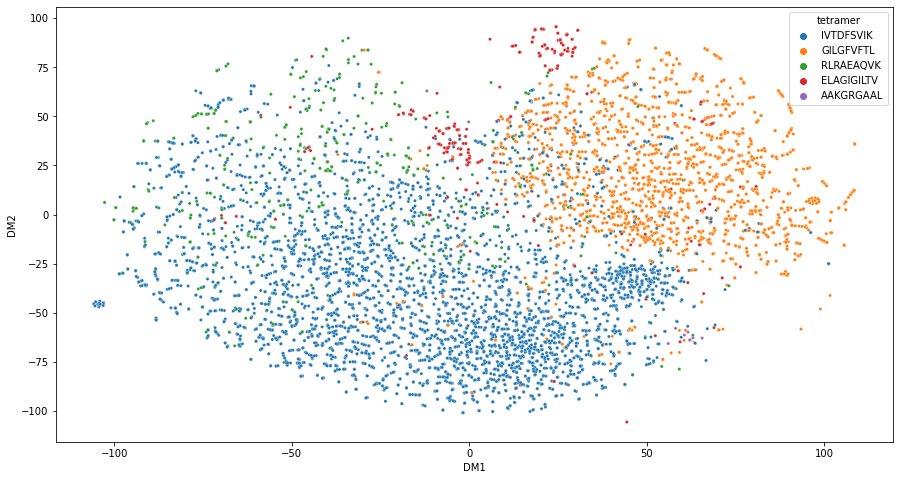

In [238]:
X_embedded = tsne(data_c_p,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### Clustering

In [240]:
#Clustering
#Kmeans
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(n_clusters=n_tetra, random_state=0).fit(data_c_p)

In [241]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

,DM1,DM2,barcode,tetramer,cluster
0,58.700546,6.003191,AAACCTGAGATTACCC-16,AVFDRKSDAK,4
1,44.617802,-41.415318,AAACCTGAGGGAGTAA-40,IVTDFSVIK,35
2,-17.683290,110.270752,AAACCTGAGGTGCACA-13,AVFDRKSDAK,29
3,89.800735,2.452391,AAACCTGAGTGGGTTG-17,GILGFVFTL,3
4,-94.664024,-7.394604,AAACCTGAGTTTAGGA-39,IVTDFSVIK,38
...,...,...,...,...,...
12752,-61.056118,-48.220890,TTTGTCAGTGATAAGT-22,AVFDRKSDAK,7
12753,-42.167168,16.462694,TTTGTCAGTTACCGAT-20,AVFDRKSDAK,36
12754,-11.976379,62.978733,TTTGTCATCAGGTAAA-40,AAKGRGAAL,24
12755,77.353546,66.849609,TTTGTCATCGAGGTAG-13,GILGFVFTL,28


In [242]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [245]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']

kmeans = KMeans(init="k-means++", n_clusters=n_tetra, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data_c_p, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_tetra, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data_c_p, labels=labels)


#kmeans = KMeans(init=pca_model.components_, n_clusters=n_tetra, n_init=1)
#bench_k_means(kmeans=kmeans, name="PCA-based", data=pca_df, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.650s	387490	0.241	0.122	0.162	0.043	0.145	-0.088
random   	1.460s	391851	0.248	0.123	0.165	0.039	0.148	-0.034
__________________________________________________________________________________
